In [153]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  ## remove pandas future warning

from urllib.request import urlopen
import kglab
from rdflib import Graph, plugin
from rdflib.serializer import Serializer
import pandas as pd
import seaborn as sns
from rdflib import Graph  #, plugin
import matplotlib.pyplot as plt
import boto3

# pyshack sends output to log along with the vars.  This suppresses that
import logging, sys
logging.disable(sys.maxsize)

import time, io
from datetime import datetime
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter
from reportlab.platypus import *
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch
from reportlab.platypus.tables import Table
from reportlab.platypus import SimpleDocTemplate

In [154]:
namespaces = {
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

In [165]:
sg = open("shape.ttl", "r")
#sg = urlopen("https://raw.githubusercontent.com/iodepo/odis-arch/master/validation/SHACL/GeoCodesv1Shapes.ttl")
from minio import Minio

# Create client with access and secret key.
client = Minio("oss.geocodes.ncsa.illinois.edu:443", "worldsbestaccesskey", "worldsbestsecretkey")
path = f"milled/iris/001dcdf99c383571c0479c00def62ed953c83a92.rdf"
response = client.get_object("yybucket", path)
#print(response.data)
rdf = response.data

path = f"milled/iris/0fd127b2c8b80333875caea41a78c6a7cfeea983.rdf"
response = client.get_object("yybucket", path)
#print(response.data)
rdf = rdf + response.data

path = f"summoned/iris/001dcdf99c383571c0479c00def62ed953c83a92.jsonld"
response = client.get_object("yybucket", path)
jsonld = response.data

path = f"graphs/latest/iedadata_release.nq"
response = client.get_object("yybucket", path)
nq = response.data

dg = nq

In [166]:
fna = []   # array to hold errors
try:
    g = Graph().parse(dg, format='nquads')
    #g = Graph().parse(dg, format='n3')
    result = g.serialize(format='ttl')# .decode('utf-8')
    kg.load_rdf_text(result)
except:
    print("An exception occurred with {}".format(fn))
    fna.append(fn)

conforms, report_graph, report_text = kg.validate(
    shacl_graph=sg,
    shacl_graph_format="ttl"
)

# print(report_text)
# print(fna)

kg.load_rdf_text(data=report_graph.save_rdf_text(), format="ttl")

Checking 49452942 object(s)
severity                                            shacl:Violation  \
message                                                               
Dataset identifier is required and must be a UR...                0   
Expecting SO namespace of <http://schema.org/> ...                3   
Indicate if the dataset is accessible without m...                0   
Name is required; Dataset names must have at le...                3   
YY TEST                                                           3   
license items must be a string, URL or schema:C...                0   

severity                                            shacl:Warning  
message                                                            
Dataset identifier is required and must be a UR...              3  
Expecting SO namespace of <http://schema.org/> ...              0  
Indicate if the dataset is accessible without m...              3  
Name is required; Dataset names must have at le...             

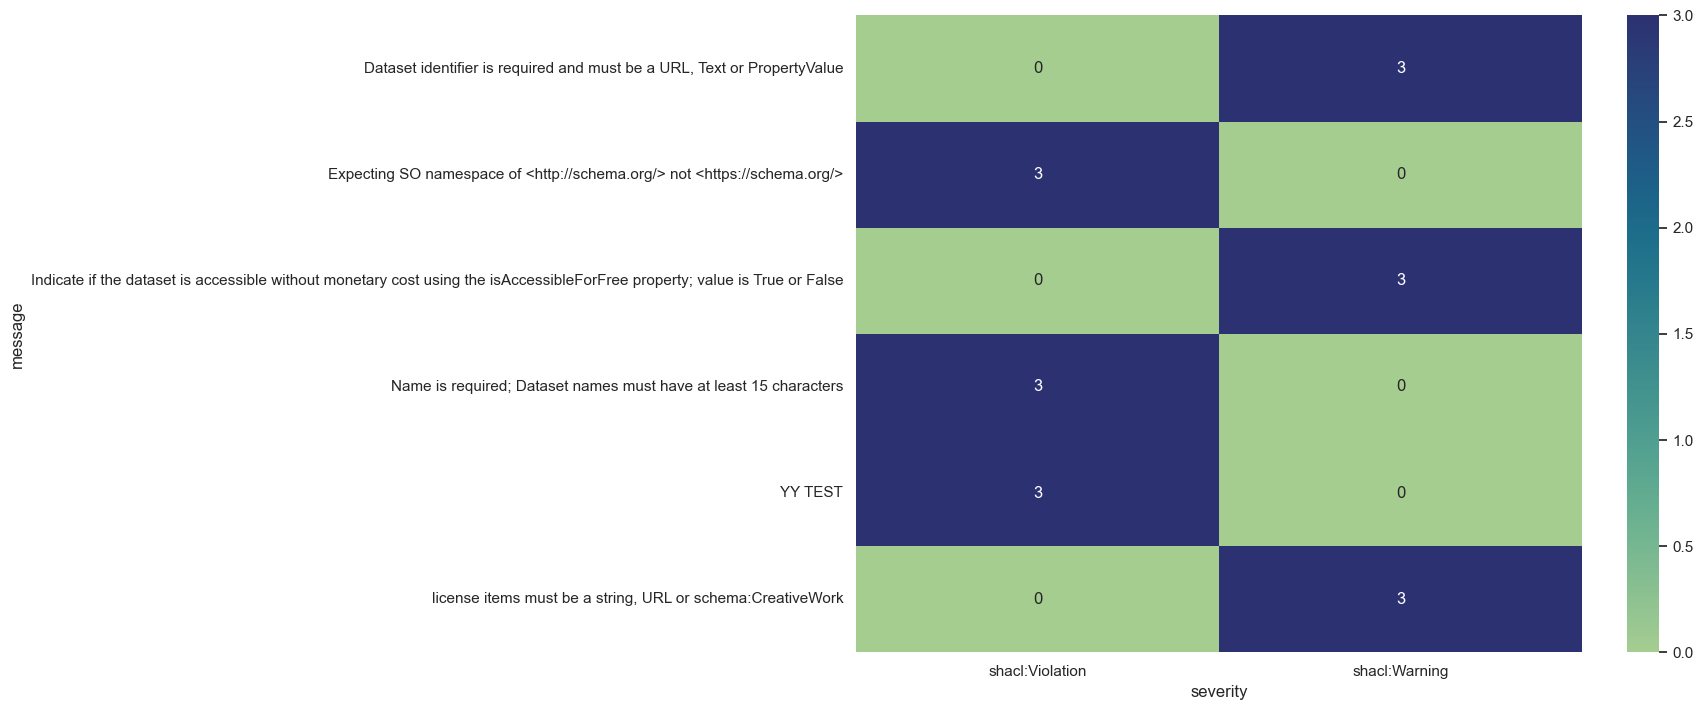

In [167]:
# SELECT  ?severity  ?constraint ?path ?message ?focus ?path ?value ?id

sparql = """
SELECT  ?severity  ?constraint ?path ?message ?focus ?path ?value
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

pdf = kg.query_as_df(sparql)
df = pdf  #.to_pandas()  #  including .to_pandas() breaks with papermill for reasons unknown at this time if to_pandas() is used, needed in my kglab conda env

if 'severity' in df.columns:
    dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})
    ctst = pd.crosstab(df['message'], df['severity'],  margins = False , margins_name = 'Totals')

    s1 = str("Checking {} object(s)".format(len(dg) ))
    print(s1)
    print(ctst)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.heatmap(ctst, annot=True, fmt=".0f", cmap = sns.cm.crest)
    #plt.savefig('./output/heatmap_{}.png'.format(date_time))
else:
    print("No severity column found, all SHACL validations must have passed.")